<a href="https://colab.research.google.com/github/mojtabaSefidi/Machine-Learning-with-Graphs/blob/main/MLG_Ex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Essential Packages

In [1]:
!pip install -q torch_geometric
!pip install -q torch-sparse==0.6.13
!pip install -q torch_scatter

     |████████████████████████████████| 564 kB 4.7 MB/s 
     |████████████████████████████████| 280 kB 47.4 MB/s 
     |████████████████████████████████| 48 kB 2.3 MB/s 
     |████████████████████████████████| 106 kB 5.3 MB/s 


## Install Essential Libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import networkx as nx
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.loader import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool

In [28]:
def plot_history(list_train_loss, list_train_acc, list_val_loss, list_val_acc, n_epochs, title):
    
    plt.figure(figsize=(18,8),linewidth = 7, edgecolor="whitesmoke")    
    n = n_epochs
    
    plt.plot(list(range(1, n_epochs+1)), list_train_acc, color='orange',marker=".")
    plt.plot(list(range(1, n_epochs+1)), list_train_loss,'b',marker=".")
    
    plt.plot(list(range(1, n_epochs+1)), list_val_acc,'r')  
    plt.plot(list(range(1, n_epochs+1)), list_val_loss,'g')
    
    plt.legend(['Train Accuracy','Train Loss','Test Accuracy','Test Loss'])
    plt.grid(True)
    
    # plt.gca().set_ylim(0,1)

    plt.xlabel("Number of Epochs")
    plt.ylabel("Value")
    plt.suptitle(title, size=16, y=0.927)
    plt.show()

## Read the Dataset

In [4]:
dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG', transform=NormalizeFeatures())

Extracting /tmp/MUTAG/MUTAG/MUTAG.zip
Processing...
Done!


## Split the Dataset

In [29]:
def split_data(dataset, train_split_percentage):
  cut_index = int(len(dataset) * train_split_percentage)
  dataset = dataset.shuffle()
  return dataset[:cut_index], dataset[cut_index:]

In [48]:
train_dataset, test_dataset = split_data(dataset, train_split_percentage=0.75)
print(len(train_dataset), len(test_dataset))

141 47


## Batch Generator

In [49]:
def batch_generator(train_dataset, test_dataset, batch_size, shuffle=True):
  train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
  test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
  return train_data_loader, test_data_loader

In [50]:
train_data_loader, test_data_loader =  batch_generator(train_dataset, test_dataset, batch_size=64)

for batch, data in enumerate(train_data_loader):
    print(f'Batch {batch + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()


Batch 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2584], x=[1168, 7], edge_attr=[2584, 4], y=[64], batch=[1168], ptr=[65])

Batch 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2454], x=[1118, 7], edge_attr=[2454, 4], y=[64], batch=[1118], ptr=[65])

Batch 3:
Number of graphs in the current batch: 13
DataBatch(edge_index=[2, 568], x=[254, 7], edge_attr=[568, 4], y=[13], batch=[254], ptr=[14])



In [51]:
class GCN_Mean(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN_Mean, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x


In [52]:
class GCN_Max(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN_Max, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):

        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)

        x = global_max_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [53]:
class GCN_Add(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN_Add, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)

        x = global_add_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

### Mean Pooling

In [86]:
model = GCN_Mean(hidden_channels=64)
print(model)

GCN_Mean(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [87]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.006)
criterion = torch.nn.CrossEntropyLoss()

def train(data_loader):
    model.train()

    for data in data_loader:
         out = model(data.x, data.edge_index, data.batch)
         loss = criterion(out, data.y)
         loss.backward()
         optimizer.step()
         optimizer.zero_grad()

def evaluate(data_loader):
     model.eval()

     correct, loss = 0, 0
     for data in data_loader:
         out = model(data.x, data.edge_index, data.batch)
         loss += criterion(out, data.y)  
         pred = out.argmax(dim=1)
         correct += int((pred == data.y).sum())
     return correct / len(data_loader.dataset), loss/ len(data_loader.dataset)

def train_and_evaluate(train_data_loader, test_data_loader, n_epochs=200):
  
  list_train_acc, list_train_loss, list_test_acc, list_test_loss = [], [], [], []
  for epoch in range(1, n_epochs+1):
      train(train_data_loader)
      
      train_accuracy, train_loss = evaluate(train_data_loader)
      list_train_acc.append(train_accuracy)
      list_train_loss.append(float(train_loss.detach()))
      
      test_accuracy, test_loss = evaluate(test_data_loader)
      list_test_acc.append(test_accuracy)
      list_test_loss.append(float(test_loss.detach()))

      print(f'Epoch: {epoch:03d}, Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}')
  
  return list_train_acc, list_train_loss, list_test_acc, list_test_loss

In [88]:
list_train_acc, list_train_loss, list_test_acc, list_test_loss = train_and_evaluate(train_data_loader, test_data_loader, n_epochs=200)

Epoch: 001, Train Accuracy: 0.6809, Train Loss: 0.0138, Test Accuracy: 0.6170, Test Loss: 0.0140
Epoch: 002, Train Accuracy: 0.6809, Train Loss: 0.0136, Test Accuracy: 0.6170, Test Loss: 0.0144
Epoch: 003, Train Accuracy: 0.6809, Train Loss: 0.0122, Test Accuracy: 0.6170, Test Loss: 0.0141
Epoch: 004, Train Accuracy: 0.6809, Train Loss: 0.0128, Test Accuracy: 0.6170, Test Loss: 0.0138
Epoch: 005, Train Accuracy: 0.6809, Train Loss: 0.0134, Test Accuracy: 0.6170, Test Loss: 0.0138
Epoch: 006, Train Accuracy: 0.6809, Train Loss: 0.0128, Test Accuracy: 0.6170, Test Loss: 0.0137
Epoch: 007, Train Accuracy: 0.6809, Train Loss: 0.0141, Test Accuracy: 0.6170, Test Loss: 0.0137
Epoch: 008, Train Accuracy: 0.6809, Train Loss: 0.0140, Test Accuracy: 0.6170, Test Loss: 0.0135
Epoch: 009, Train Accuracy: 0.6809, Train Loss: 0.0129, Test Accuracy: 0.6170, Test Loss: 0.0130
Epoch: 010, Train Accuracy: 0.6809, Train Loss: 0.0119, Test Accuracy: 0.6170, Test Loss: 0.0127
Epoch: 011, Train Accuracy: 0.

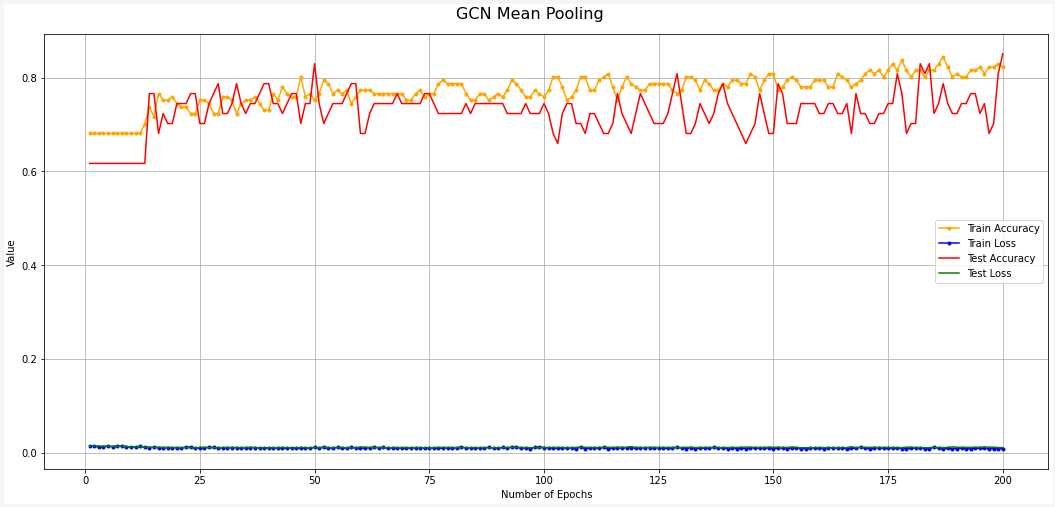

In [89]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=200, title='GCN Mean Pooling')

### Max Pooling

In [90]:
model = GCN_Add(hidden_channels=64)
print(model)

GCN_Add(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [91]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.006)
criterion = torch.nn.CrossEntropyLoss()

In [92]:
list_train_acc, list_train_loss, list_test_acc, list_test_loss = train_and_evaluate(train_data_loader, test_data_loader, n_epochs=200)

Epoch: 001, Train Accuracy: 0.6809, Train Loss: 0.0157, Test Accuracy: 0.6170, Test Loss: 0.0156
Epoch: 002, Train Accuracy: 0.6809, Train Loss: 0.0129, Test Accuracy: 0.6170, Test Loss: 0.0131
Epoch: 003, Train Accuracy: 0.6809, Train Loss: 0.0124, Test Accuracy: 0.6170, Test Loss: 0.0131
Epoch: 004, Train Accuracy: 0.6809, Train Loss: 0.0113, Test Accuracy: 0.6170, Test Loss: 0.0125
Epoch: 005, Train Accuracy: 0.6809, Train Loss: 0.0127, Test Accuracy: 0.6170, Test Loss: 0.0126
Epoch: 006, Train Accuracy: 0.6809, Train Loss: 0.0119, Test Accuracy: 0.6170, Test Loss: 0.0122
Epoch: 007, Train Accuracy: 0.6809, Train Loss: 0.0125, Test Accuracy: 0.6170, Test Loss: 0.0120
Epoch: 008, Train Accuracy: 0.6809, Train Loss: 0.0131, Test Accuracy: 0.6170, Test Loss: 0.0119
Epoch: 009, Train Accuracy: 0.6809, Train Loss: 0.0117, Test Accuracy: 0.6170, Test Loss: 0.0115
Epoch: 010, Train Accuracy: 0.7163, Train Loss: 0.0108, Test Accuracy: 0.6170, Test Loss: 0.0111
Epoch: 011, Train Accuracy: 0.

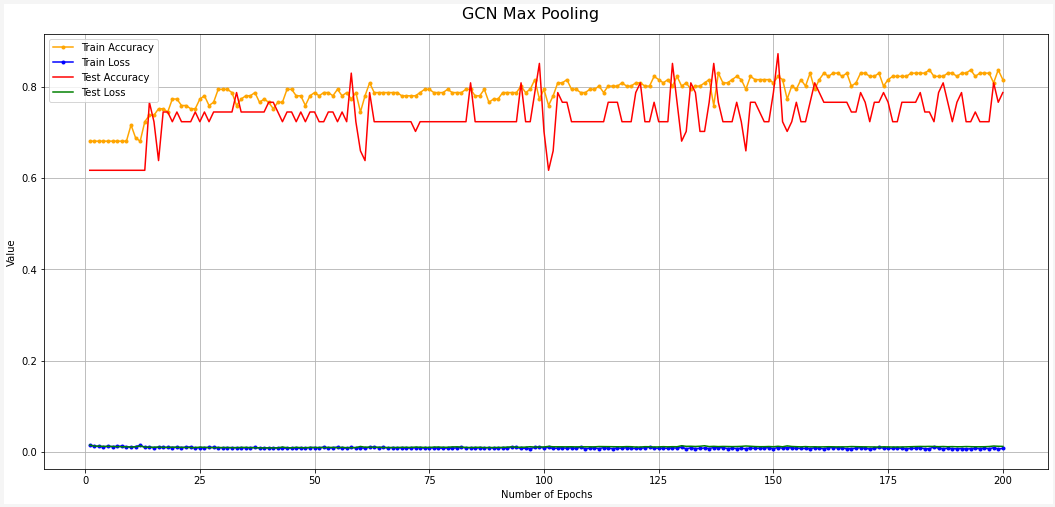

In [93]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=200, title='GCN Max Pooling')

### Add Pooling

In [94]:
model = GCN_Add(hidden_channels=64)
print(model)

GCN_Add(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [95]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.006)
criterion = torch.nn.CrossEntropyLoss()

In [96]:
list_train_acc, list_train_loss, list_test_acc, list_test_loss = train_and_evaluate(train_data_loader, test_data_loader, n_epochs=200)

Epoch: 001, Train Accuracy: 0.6809, Train Loss: 0.0157, Test Accuracy: 0.6170, Test Loss: 0.0156
Epoch: 002, Train Accuracy: 0.6809, Train Loss: 0.0129, Test Accuracy: 0.6170, Test Loss: 0.0131
Epoch: 003, Train Accuracy: 0.6809, Train Loss: 0.0124, Test Accuracy: 0.6170, Test Loss: 0.0131
Epoch: 004, Train Accuracy: 0.6809, Train Loss: 0.0113, Test Accuracy: 0.6170, Test Loss: 0.0125
Epoch: 005, Train Accuracy: 0.6809, Train Loss: 0.0127, Test Accuracy: 0.6170, Test Loss: 0.0126
Epoch: 006, Train Accuracy: 0.6809, Train Loss: 0.0119, Test Accuracy: 0.6170, Test Loss: 0.0122
Epoch: 007, Train Accuracy: 0.6809, Train Loss: 0.0125, Test Accuracy: 0.6170, Test Loss: 0.0120
Epoch: 008, Train Accuracy: 0.6809, Train Loss: 0.0131, Test Accuracy: 0.6170, Test Loss: 0.0119
Epoch: 009, Train Accuracy: 0.6809, Train Loss: 0.0117, Test Accuracy: 0.6170, Test Loss: 0.0115
Epoch: 010, Train Accuracy: 0.7163, Train Loss: 0.0108, Test Accuracy: 0.6170, Test Loss: 0.0111
Epoch: 011, Train Accuracy: 0.

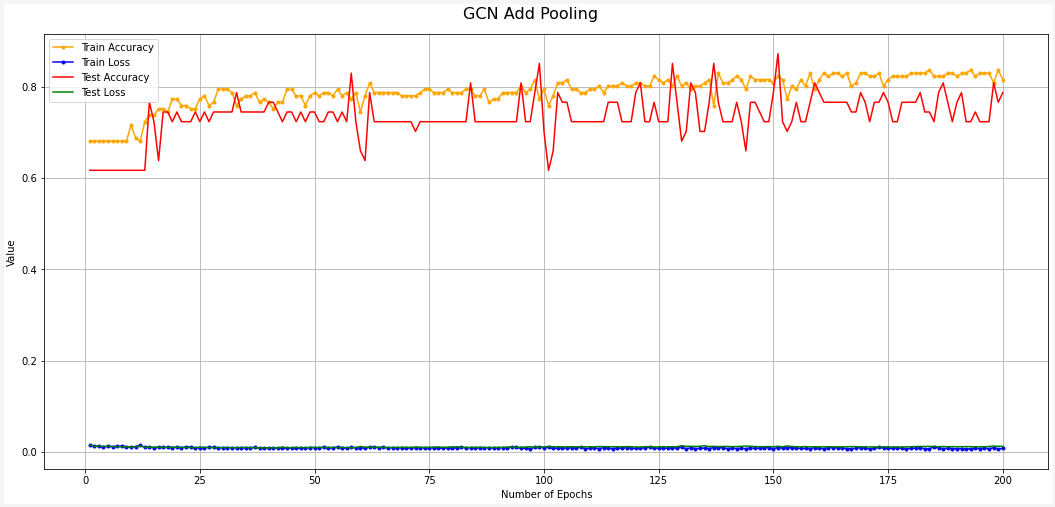

In [97]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=200, title='GCN Add Pooling')